In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
import numpy as np
import torch
from geometry import *
from utils import Plot_Grid
from solver import *
from models import *
from mesh import *
from boundary import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nx, ny = 70, 70
xi_, eta_ = np.linspace(0,1,nx), np.linspace(0,1,ny)
xi, eta = np.meshgrid(xi_, eta_)
anulus = Analytical_Annulus(1., 0.6, 0.)
grid = TFI(xi, eta, anulus)()

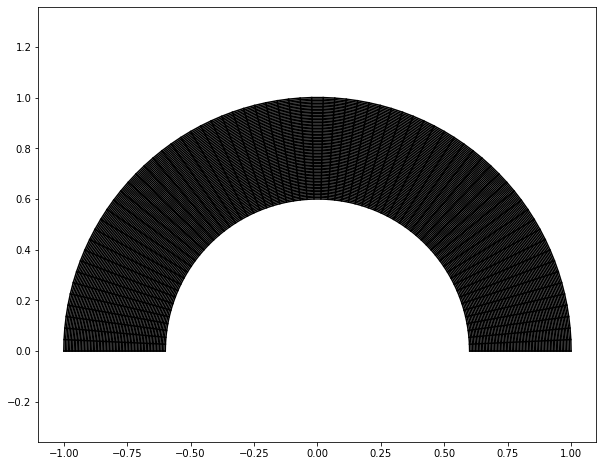

In [3]:
Plot_Grid(grid['x'],grid['y'],nx,ny)

In [4]:
# Code the governing Equation

# give the value of tau, n and K 
tau = 0.
n = 0.5
K = 1.02
dpdz = 1.0

class Guv_Eq(Transformed_PDE):
    
    def PDELoss(self, inputs, computation, outputs):
        
        # Calculate the determinant
        jac_det = self.jacobian_det(computation)
        
        # calculate alpha 
        alpha = self.alpha(computation)
        
        # calculate beta
        beta = self.beta(computation)
        
        # calculate gamma
        gamma = self.gamma(computation)
        
        # compute the gradient of U wrt inputs 
        gradient = self.compute_grad(outputs, inputs)
        
        # seperate dudxi and dudeta
        dudxi = gradient[:,0]
        dudeta = gradient[:,1]
        
        # calculate apparent viscosity
        app_visc = self.HB_model(computation, gradient, tau, n, K)
        
        # code part(a) of the governing equation
        left = (app_visc)*(alpha*dudxi - gamma*dudeta)
        
        # code part(b) of the governing equation
        right = (app_visc)*(beta*dudeta - gamma*dudxi)
        
        # differentiate part(a) wrt xi
        d_left_dxi = self.compute_grad(left, inputs)[:,0]
        
        # differentiate part(b) wrt eta
        d_right_deta = self.compute_grad(right, inputs)[:,1]
        
        # combine the left and right with dpdz for loss function
        gov_eq = d_left_dxi + d_right_deta + jac_det**4*dpdz
        
        return {'PDE': gov_eq}
        
    
    def shear_rate(self, computation, gradient):
        
        # calculate the determinant
        jac_det = self.jacobian_det(computation)
        
        # seperate the input 
        dxdxi, dxdeta, dydxi, dydeta = self.seperate_data(computation)
        
        # seperate the gradients
        dudxi = gradient[:,0]
        dudeta = gradient[:,1]
        
        # compute the shear rate
        sr = (((dydeta*dudxi - dydxi*dudeta)**2 + (dxdxi*dudeta - dxdeta*dudxi)**2)/ jac_det**2)**(0.5)
        
        return sr
        
    
    def Modified_HB(self, inputs, outputs):
        pass
    
    def HB_model(self, computation, gradients,tau, n, K):
        
        # determine the shear rate
        shear_rate = self.shear_rate(computation, gradients)
        
        # calculate the apparent viscosity
        app_vis_ = (tau/shear_rate) + ((shear_rate)**(n-1))*K
        
        app_vis = torch.where(app_vis_>torch.from_numpy(np.array([1e-5])).float(),app_vis_,torch.from_numpy(np.array([1e-5])).float())
        
        return app_vis
    
    def jacobian_det(self, computation):
        dxdxi, dxdeta, dydxi, dydeta = self.seperate_data(computation)
        jac_det = dxdxi*dydeta-dxdeta*dydxi
        return jac_det
    
    def alpha(self, computation):
        dxdxi, dxdeta, dydxi, dydeta = self.seperate_data(computation)
        return dxdeta**2 + dydeta**2
    
    def beta(self, computation):
        dxdxi, dxdeta, dydxi, dydeta = self.seperate_data(computation)
        return dxdxi**2 + dydxi**2
    
    def gamma(self, computation):
        dxdxi, dxdeta, dydxi, dydeta = self.seperate_data(computation)
        return dxdxi*dxdeta + dydeta*dydxi
    
    def seperate_data(self,computation):
        dxdxi = computation[:,0]
        dxdeta = computation[:,1]
        dydxi = computation[:,2]
        dydeta = computation[:,3]
        return dxdxi, dxdeta, dydxi, dydeta
    

# initiate the PDE equation
pde = Guv_Eq(inputs=('xi', 'eta'),computation = ('dxdxi', 'dxdeta', 'dydxi', 'dydeta'), outputs='u')


pass


In [5]:
def comp_data(data):
    dxdxi = data[:,0]
    dxdeta = data[:,1]
    dydxi = data[:,2]
    dydeta = data[:,3]
    jac = data[:,4]
    djdxi = data[:,5]
    djdeta = data[:,6]
    return dxdxi, dxdeta, dydxi, dydeta, jac, djdxi, djdeta

In [6]:
# define the meshing data
mesh = Mesh_Data({'xi':xi, 'eta':eta},
                 {'dxdxi':grid['dxdxi'], 'dxdeta': grid['dxdeta'],
                  'dydxi': grid['dydxi'], 'dydeta':grid['dydeta'],
                 'jac': grid['jac'], 'djdxi':grid['djdxi'], 'djdeta':grid['djdeta']})



KeyError: 'jac'

In [ ]:
dxdxi, dxdeta, dydxi, dydeta, jac, djdxi, djdeta= comp_data(mesh.gen_data[:][1])

In [ ]:
pde.set_mesh(mesh)

In [ ]:
# left and right boundary conditions
# u = 0 @ eta = 0 and eta = 1
# using dirichlet boundary conditions
# xi_diri = np.linspace(0,1,nx)
eta_diri = np.array([0,1])
# xi_, eta_ = np.meshgrid(xi_diri, eta_diri)
u_ = np.full(2*len(xi_),0.)
pipe = Dirichlet({'xi':xi_, 'eta': eta_diri}, {'u':u_}, name='Inner_Outer')
pde.add_boundary(pipe)

In [ ]:
# top boundary
# dudxi = 0 @ xi = 0, 1
#eta_nu = np.linspace(0,1,ny)
xi_nu = np.array([0,1])
#xi_, eta_ = np.meshgrid(xi_nu, eta_nu)
#u_ = np.zeros_like(xi_).reshape(-1)
class Neumann(Neumann):
    def neumann_loss(self, inputs, outputs):
        dudxi = self.compute_grad(outputs, inputs)[:,0]
        return {'gradXi': dudxi}
outer = Neumann({'xi':xi_nu, 'eta': eta_}, device=mesh.device, name='Left_flank')
pde.add_boundary(outer)

In [ ]:
btach_size = 512
lr = 4e-3
epochs = 100
hid_dim = 150
layers = 3
in_dim = len(pde.input)
out_dim = len(pde.output)
activation = Sine()
#activation = torch.nn.Tanh()

net = Neural_Net(in_dim, hid_dim, out_dim, layers, act= activation)

optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start=0.1, total_steps=epochs)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,cycle_momentum=True)

pde.compile(net,optimizer, scheduler)

In [ ]:
%time hist = pde.solve(epochs, btach_size)

In [ ]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

In [ ]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)

eval_mesh = Mesh({'x':x, 'y':y})
pred = pde.eval(eval_mesh).view(len(y),len(x)).numpy()

In [ ]:
pred.shape

In [ ]:
plt.figure(figsize=(10,8))
plt.contourf(grid.X()['x'],grid.Y()['y'], pred.T, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

In [ ]:
test = np.gradient(grid.X()['x'], 0.02, 0.02)[0]

In [ ]:
np.allclose(grid.X()['dxdxi'], test)

In [ ]:
in_data, comp_data = mesh.gen_data[:]

In [ ]:
test_2 = comp_data[:,1].numpy()

In [ ]:
np.allclose(grid.X()['dxdeta'], test_2.reshape(50,50))